<a href="https://colab.research.google.com/github/VejAlDatt/Prediction-System-for-Emergency-Operators/blob/main/Forcast_FinalModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Final Model**



This model is purposeful to predict the daily standby drivers needed, such that the percentage of standby drivers deployed are higher than the previous approach of keeping 90 drivers on hold.

In [37]:
#Importation of various libraries for data analysis and machine learning

import pandas
import numpy
import matplotlib.pyplot
import datetime
import warnings
import keras.utils
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import sklearn
from sklearn import *


In [38]:

#Reads the dataset into a Pandas dataframe, converts the "date" column into a datetime format, 
#adds columns for year, month, day of the week, week of the year, day of the month, 
#and day of the year using Pandas datetime functions.

warnings.filterwarnings('ignore')
sicknessDataframe = pandas.read_csv('/content/sickness_table.csv', delimiter=None, squeeze=False,index_col=0)
sicknessDataframe['date'] = pandas.to_datetime(sicknessDataframe['date'], yearfirst=False, exact=True)
sicknessDataframe['year']= sicknessDataframe['date'].dt.year
sicknessDataframe['month']= sicknessDataframe['date'].dt.month
sicknessDataframe['weekly_day'] = sicknessDataframe['date'].dt.day_of_week 
sicknessDataframe['week'] = sicknessDataframe['date'].dt.weekofyear 
sicknessDataframe['day_in_month'] = sicknessDataframe['date'].dt.day
sicknessDataframe['day_in_year'] = sicknessDataframe['date'].dt.dayofyear



**Model Selection**

In this model selection phase, two regression models, namely XGBoost and Random Forest, were trained on selected features of the dataset to predict the number of standby drivers based on the number of calls. The determination of most optimal regression model was determined by comparing the mean square error (MSE) from both models, where the model with the lowest MSE was deemed the most optimal model.

In [39]:
#function will model, split and forcast based on the provided inputs
def model_fit_predict(dataX, dataY, mlmodel, idx=922):
  trainX, testX = dataX[:idx], dataX[idx:]
  trainY, testY = dataY[:idx], dataY[idx:]
  mlmodel.fit(trainX, trainY)
  return mlmodel.predict(testX), testY

#XGBoost - Making prediction based on the number of emergency calls received 
calls_pred, calls_test = model_fit_predict(sicknessDataframe[['year', 'month', 'weekly_day', 'week']].values, sicknessDataframe.calls.values, mlmodel=XGBRegressor())
sicknessDataframe['calls_new'] = numpy.concatenate((sicknessDataframe['calls'].iloc[:922].values, calls_pred))
#XGBoost - Making the standby drivers prediction based on the number of emergency calls received 
sby_pred, sby_test = model_fit_predict(sicknessDataframe[['year', 'month', 'weekly_day', 'week', 'calls_new']].values, sicknessDataframe.sby_need.values,mlmodel=XGBRegressor())
print('(XGBoost) The MSE for forcasting standby drivers based on calls is', mean_squared_error(sby_test, sby_pred))

#Random Forest - Making prediction based on the number of emergency calls received 
calls_pred, calls_test = model_fit_predict(sicknessDataframe[['year', 'month', 'weekly_day', 'week']].values, sicknessDataframe.calls.values, mlmodel=RandomForestRegressor())
sicknessDataframe['calls_new'] = numpy.concatenate((sicknessDataframe['calls'].iloc[:922].values, calls_pred))
#Random Forest - Making the standby drivers prediction based on the number of emergency calls received 
sby_pred, sby_test = model_fit_predict(sicknessDataframe[['year', 'month', 'weekly_day', 'week', 'calls_new']].values, sicknessDataframe.sby_need.values,mlmodel=RandomForestRegressor())
print('(Random Forest) The MSE for forcasting standby drivers based on calls is', mean_squared_error(sby_test, sby_pred))


[17:16:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:16:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
(XGBoost) The MSE for forcasting standby drivers based on calls is 14477.635004645661
(Random Forest) The MSE for forcasting standby drivers based on calls is 12644.686177391304


In [40]:
sicknessDataframe.drop(columns=['calls_new'], inplace=True)

Finding: *A Random Forest regression model will be used to predict the "sby_need" based on the predicted values of "calls"*

In [41]:
'''
The provided sickness dataset is splitted into two dataframe. DataframeX contains datetime variables from the dataset,
whiles DataframeY contains the "calls" column. Further, each of the aforementioned dataframes are splitted into training sets 
(first 922 rows) and testing sets (rest of the rows).
'''

dataframeX  = sicknessDataframe[sicknessDataframe.columns[7:13]]
dataframeY = sicknessDataframe['calls']

def datasetSplit(dataset):
	return dataset[:922], dataset[922:]

trainX, testX = datasetSplit(dataframeX)
trainY, testY = datasetSplit(dataframeY)



In [42]:
#Model is an instance of the RandomForestRegressor class
model = sklearn.ensemble.RandomForestRegressor(n_estimators=1000, random_state=6)
#Training the model on the training data
model.fit(trainX, trainY)
#Making predictions on the test data 
pred = model.predict(testX)

In [43]:
'''
Creating a new dataframe by selecting the 'calls' column from the 'sicknessDataframe', renames it to 'Initial data' 
and creates another dataframe with a single column 'forecast' storing the values of 'pred' variable above.
'''
Real_dataframe = sicknessDataframe[['calls']]
Real_dataframe.rename(columns = {'calls':'Initial data'}, inplace = True)
data_forcast = pandas.DataFrame(data = {'forecast': pred})

**Model Tuning**

In [44]:
'''
Retrieving the parameters of the model defined above, then printing 
the value from the returned dictionary ‘rfvar’
'''
rfvar = model.get_params()
for key, value in rfvar.items():
 print(f'{key}: {value}')


bootstrap: True
ccp_alpha: 0.0
criterion: squared_error
max_depth: None
max_features: auto
max_leaf_nodes: None
max_samples: None
min_impurity_decrease: 0.0
min_samples_leaf: 1
min_samples_split: 2
min_weight_fraction_leaf: 0.0
n_estimators: 1000
n_jobs: None
oob_score: False
random_state: 6
verbose: 0
warm_start: False


In [45]:
'''
Defining several hyperparameter values to be used in the randomised and 
grid search phase of the model training process
'''
n_estimators = list(range(200,2001,200))
max_features = [ 'auto','sqrt']
max_depth = list(range(10,111,10)) + [None]
min_samples_split = [x for x in [2, 5, 10]]
min_samples_leaf = [x for x in [1, 2, 4]]    
bootstrap = [True, False]


In [46]:

#Creating a key-value paired dictionary that contains the aforestated hyperparameters

rfDataMatrix = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [47]:

# Note: This code was executed and covered, since it took an exorbitantly long time to execute. The output is documented below.

#Creating an instance of RandomForestRegressor()
#dataModel = sklearn.ensemble.RandomForestRegressor()

#Performing random search with cross-validation to find the best hyperparameters for the model
#dataModelR = RandomizedSearchCV(estimator = dataModel , param_distributions = rfDataMatrix, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)

#Fitting the dataModelR to the training data and target values
#dataModelR.fit(trainX, trainY)




Output of parameters:
{'n_estimators': 2000,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 10,
 'bootstrap': True}

In [48]:
#Initializing a random forest regression model
modelA = sklearn.ensemble.RandomForestRegressor(n_estimators = 1000, random_state = 6)
#Fit the model to the training data 
modelA.fit(trainX, trainY)
#Calculating the MSE & RMSE between the true values and the predictions
MeanSquareError = sklearn.metrics.mean_squared_error(testY, modelA.predict(testX))
RootMeanSquareError = round(numpy.sqrt(MeanSquareError), 2)
print(f'MSE is {MeanSquareError} and RSME is {RootMeanSquareError}')


MSE is 1527716.7756915651 and RSME is 1236.01


In [49]:
'''
Performing grid search cross-validation to find the best hyperparameters for the model by fitting it to the training data
'''
#Takes some time to execute
parameters= dict(bootstrap=[True], max_depth=[0, 10, 20], max_features=['sqrt'], 
              min_samples_leaf=[1, 2, 3], min_samples_split=[3, 5, 7], n_estimators=[1800, 2000, 2200])

model = sklearn.ensemble.RandomForestRegressor()
grid = sklearn.model_selection.GridSearchCV(model, parameters, cv=3, n_jobs=-1, verbose=2).fit(trainX, trainY)

Fitting 3 folds for each of 81 candidates, totalling 243 fits


Best Parameters:
<br>
{'bootstrap': True,
 'max_depth': 10,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 7,
 'n_estimators': 1800}

In [50]:
'''
 Selecting the best estimator from the grid search cross-validation, 
 and calculating the mean squared error and root mean squared error of the prediction on test data
'''

gridBest = grid.best_estimator_ 

MeanSquareError = sklearn.metrics.mean_squared_error(testY, gridBest.predict(testX))
RootMeanSquareError = round(numpy.sqrt(MeanSquareError), 2)
print(f'MSE is {MeanSquareError} and RSME is {RootMeanSquareError}')


MSE is 1466642.7151082344 and RSME is 1211.05


**Forcast using updated parameters**

In [51]:
'''
The model was trained on specific hyperparameters, fitted to the training data, 
in order to make predictions on the test data. The model's performance was then evaluated
'''

rf_reg = sklearn.ensemble.RandomForestRegressor(bootstrap=True, max_depth=10, max_features='sqrt',
                                min_samples_leaf=1, min_samples_split=7, n_estimators=1800, random_state=6)
rf_reg.fit(trainX, trainY)
predictions = rf_reg.predict(testX)
print("Evaluation of the model:")
MeanSquareError = sklearn.metrics.mean_squared_error(testY, rf_reg.predict(testX))
RootMeanSquareError = round(numpy.sqrt(MeanSquareError), 2)
print(f'MSE is {MeanSquareError} and RSME is {RootMeanSquareError}')


Evaluation of the model:
MSE is 1475635.4393029185 and RSME is 1214.76


In [52]:
rf_reg.predict(trainX)
#Calculating the MSE and the RMSE between the actual values and the predictions
MeanSquareError = sklearn.metrics.mean_squared_error(trainY, rf_reg.predict(trainX))
RootMeanSquareError = round(numpy.sqrt(MeanSquareError), 2)
print(f'MSE is {MeanSquareError} and RSME is {RootMeanSquareError}')


MSE is 417187.7318137419 and RSME is 645.9


**Prediction for emergency standby drivers based on the predicted calls.**

In [53]:
'''
The code provided below concatenates the first 922 values of the "calls" column from the "sicknessDataframe"
and the "forecast" column from the "data_forcast" dataframe into a new dataframe named "recentCalls".

It then creates a copy of the original "sicknessDataframe" and assigns the "recentCalls" dataframe 
as the new values for the "recentCalls" column in the copy, which is stored in the "preliminarySicknessDataframe".

'''
recentCalls = pandas.concat([sicknessDataframe['calls'].T.head(922).T, data_forcast['forecast']]).reset_index(level = None, drop=True)
preliminarySicknessDataframe = sicknessDataframe.copy(deep=True)
preliminarySicknessDataframe['recentCalls'] = recentCalls



In [54]:

#Designating date variables, and the "call" variable to the dataframe
dataframe_X = preliminarySicknessDataframe.iloc[:, [7,8,9,10,3,11,12,13]]
#Designating the "sby_need" variable to the dataframe
dataframe_Y = preliminarySicknessDataframe.iloc[:,5]




In [55]:

#Spliting the dataframe to train the ML model
trainX, testX = datasetSplit(dataframe_X)
trainY, testY = datasetSplit(dataframe_Y)


In [56]:

#Creates an instance of a Random Forest Regressor model, then fit to the training data 'trainX' and 'trainY'
rfregressor = sklearn.ensemble.RandomForestRegressor(n_estimators=1000, max_depth=None, max_leaf_nodes = None, random_state=6).fit(trainX, trainY)


[0.05613926 0.00100437 0.00176985 0.00147542 0.05494442 0.00388571
 0.00214394 0.87863703]


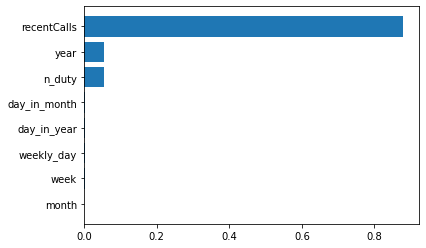

In [57]:

#Computes and visualizes the feature importances of the trained random forest regressor model
variableRank = rfregressor.feature_importances_
matplotlib.pyplot.barh(range(len(numpy.argsort(variableRank))), variableRank[numpy.argsort(variableRank)])
matplotlib.pyplot.yticks(range(len(numpy.argsort(variableRank))), numpy.array(dataframe_X.columns)[numpy.argsort(variableRank)])
print(variableRank)



In [58]:
#One-hot encodes the "year" column in the "preliminarySicknessDataframe" and adds the encoded columns to the original dataframe
encoder = pandas.DataFrame(keras.utils.to_categorical(preliminarySicknessDataframe['year'], dtype='uint8')).add_prefix('period_')
preliminarySicknessDataframe = preliminarySicknessDataframe.join(encoder)



In [59]:

#Slicing a dataframe named preliminarySicknessDataframe into two new dataframes dataX and dataY.
dataX = preliminarySicknessDataframe.iloc[:, [3,13,2030,2031,2032,2033]]
#sby_need
dataY = preliminarySicknessDataframe.iloc[:,5] 

#Further, spliting of the the dataframes dataX and dataY into training sets and test sets
trainX, testX = datasetSplit(dataX)
trainY, testY = datasetSplit(dataY)

#dataX.head()

In [60]:
#Transforming the string values into numerical labels and assigning the result back to the "year" column

preliminarySicknessDataframe['year']= sklearn.preprocessing.LabelEncoder().fit_transform(preliminarySicknessDataframe['year'])


In [61]:

#Splitting the 'preliminarySicknessDataframe' into two dataframes
dataA = preliminarySicknessDataframe.iloc[:, [3,13,7]]
#sby_need
dataB = preliminarySicknessDataframe.iloc[:,5]
#dataA.head()


In [62]:
#Splitting the previously discussed dataframes into training and testing sets
trainX, testX = datasetSplit(dataA)
trainY, testY = datasetSplit(dataB)


In [63]:
'''
Training a quantile regression model, then fit the regression model to the training data trainX and trainY,
then followed by predicting the target variable using the fitted model on the test set 
'''
modelSby_need = (sklearn.linear_model.QuantileRegressor(quantile=0.95, fit_intercept=True, solver_options=None, alpha=0.25).fit(trainX, trainY))

forecastA = modelSby_need.predict(testX)
forecastA = pandas.Series(forecastA)


In [64]:
'''
Performs evaluation of the regression model 
by computing the mean squared error (MSE) and root mean squared error (RSME) on both the test and training data.
'''

#Remove zero values
forecastA = forecastA[forecastA!=0]

Real_dataframe = pandas.DataFrame(data = {'initial_data': dataB})
data_forcast = pandas.DataFrame(data = {'forecast': forecastA})

MeanSquareError = sklearn.metrics.mean_squared_error(testY, modelSby_need.predict(testX))
RootMeanSquareError = round(numpy.sqrt(MeanSquareError), 2)
print(f'(Test) MSE is {MeanSquareError} and RSME is {RootMeanSquareError}')

MeanSquareError = sklearn.metrics.mean_squared_error(trainY, modelSby_need.predict(trainX))
RootMeanSquareError = round(numpy.sqrt(MeanSquareError), 2)
print(f'(Train) MSE is {MeanSquareError} and RSME is {RootMeanSquareError}')



(Test) MSE is 13815.570524451501 and RSME is 117.54
(Train) MSE is 14543.081209034382 and RSME is 120.59


Text(0.5, 1.0, 'Initial and Forcasted Data')

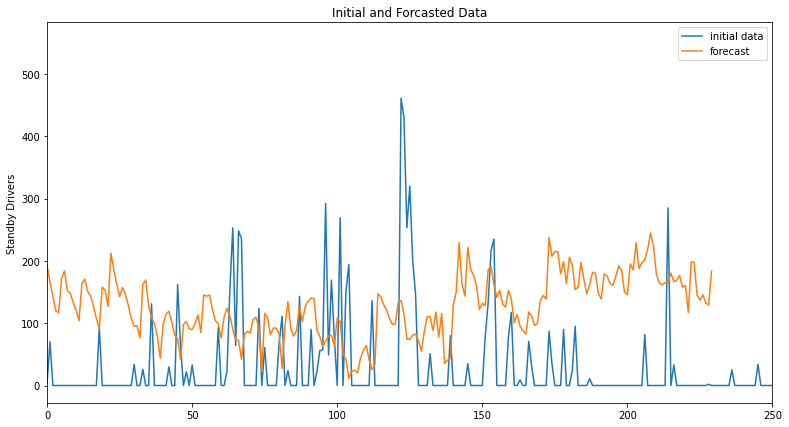

In [65]:
#Plotting to compare the initial data and the forecasted data

matplotlib.pyplot.figure(figsize=(13,7))
matplotlib.pyplot.plot(Real_dataframe['initial_data'], label = 'initial data')
matplotlib.pyplot.plot(data_forcast['forecast'], label = 'forecast')
matplotlib.pyplot.xlim([0, 250])
matplotlib.pyplot.legend()
matplotlib.pyplot.ylabel('Standby Drivers')
matplotlib.pyplot.title('Initial and Forcasted Data') 

In [66]:
#Creating a copy of the preliminarySicknessDataframe dataframe
sicknessDataframe_final = preliminarySicknessDataframe.copy(deep=True)

#Concatenating the first 922 rows of preliminarySicknessDataframe['sby_need'] and forecastA dataframes, then resetting the index
forcastStandbyRequired = pandas.concat([preliminarySicknessDataframe['sby_need'].T.head(922).T, forecastA]).reset_index(level = None, drop=True)

#Adding the forcastStandbyRequired data as a new column to the sicknessDataframe_final dataframe
sicknessDataframe_final['forcastStandbyRequired'] = forcastStandbyRequired

#Creating a new dataframe by taking all rows of sicknessDataframe_final starting from the 922nd row, then resetting the index.
driversDataframe = (sicknessDataframe_final.iloc[922:]).reset_index(level = None, drop=True)


In [67]:
'''
Calculating the shortage and excess of drivers and the average percentage of their difference 
compared to the forecasted and actual number of drivers needed.
'''

tempforcast = driversDataframe['forcastStandbyRequired']
tempActual = driversDataframe['sby_need']

varA = len(driversDataframe)/100

driversDataframe['shortage_drivers'] = numpy.where(tempforcast < tempActual, 1, 0)
driversDataframe['excess_drivers'] = numpy.where(tempforcast > tempActual, 1, 0)

shortage_drivers = driversDataframe['shortage_drivers'].sum()
excess_drivers = driversDataframe['excess_drivers'].sum()
driversDataframe['percent'] = tempforcast/tempActual

driversDataframe['percent'].replace(numpy.inf, 0, inplace=True)

percent = driversDataframe['percent'].mean()

print(f'Shortage Drivers occured for {shortage_drivers} days with a percentage of {shortage_drivers/varA}')
print(f'Excess Drivers occured for {excess_drivers} days with a percentage of {excess_drivers/varA}')
print(f'The overall mean percentage is {percent*100}')



Shortage Drivers occured for 35 days with a percentage of 15.217391304347828
Excess Drivers occured for 195 days with a percentage of 84.78260869565219
The overall mean percentage is 87.4259502656208


In [68]:
sicknessDriversForcast = pandas.DataFrame({ 'date': pandas.date_range('2019-05-28', periods=65, freq='D'), 'n_duty' : 1900}) 
sicknessDriversForcast['year'] = sicknessDriversForcast['date'].dt.year
sicknessDriversForcast['month'] = sicknessDriversForcast['date'].dt.month
sicknessDriversForcast['day_in_month'] = sicknessDriversForcast['date'].dt.day
sicknessDriversForcast['day_in_year'] = sicknessDriversForcast['date'].dt.dayofyear
sicknessDriversForcast['weekly_day'] = sicknessDriversForcast['date'].dt.day_of_week 
sicknessDriversForcast['week'] = sicknessDriversForcast['date'].dt.weekofyear 
sicknessDriversForcast['recentCalls'] = ''
sicknessDriversForcast['forcastStandbyRequired'] = ''


In [69]:
'''
Creating a new Dataframe entitled ‘sicknessDriversForcast_temp’ for some of the columns from the sicknessDataframe_final dataframe. 
Then, the ‘forcasted_calls’ Dataframe is then created by appending the ‘sicknessDriversForcast’ dataframe to the 
‘sicknessDriversForcast_temp’. Then, lastly the recent calls are predicted using the Random Forest Regressor model and 
assigned to the forcasted_calls dataframe

'''
sicknessDriversForcast_temp = sicknessDataframe_final.loc[:,:]

sicknessDriversForcast_temp = sicknessDriversForcast_temp[[column for column in sicknessDriversForcast_temp.columns if 
                                                             column not in ['calls', 'period_2016', 
                                                             'period_2017', 'period_2018', 'period_2019', 'dafted', 'n_sick', 'n_sby']]]

forcasted_calls = sicknessDriversForcast_temp.append(sicknessDriversForcast, ignore_index=True)
dataC = forcasted_calls.iloc[:, [3,4,5,6,7,8]]
#dataC.head()
forcastcalls= pandas.Series(rf_reg.predict(dataC[1152:]))
recentCalls = forcasted_calls[forcasted_calls.index < 1152]['recentCalls'].append(forcastcalls, ignore_index=True)
forcasted_calls.loc[:,'recentCalls'] = recentCalls

In [70]:
#Creating the 'dataTemp' dataframe by converting the 'year' column in  'forcasted_calls' DataFrame into one-hot encoded categorical data 
dataTemp = pandas.DataFrame(keras.utils.to_categorical(forcasted_calls['year'], dtype='uint8')).add_prefix('period_')

#Adds the one-hot encoded categorical data 'encoderB' to the 'forcasted_calls' DataFrame 
encoderB = dataTemp.iloc[:, [0,1,2,3,2019]]
forcasted_calls = forcasted_calls.join(encoderB, how = 'left', lsuffix='left', rsuffix='right')

#Predicts the 'sby_need' values
dataforcastCalls = forcasted_calls.iloc[:, [1,9,2031]]
forcastcalls= round(pandas.Series(modelSby_need.predict(dataforcastCalls[1152:])))

In [71]:

#The first 1152 rows of "forcasted_calls", which contains the "forcastStandbyRequired" column, is appended with the "forcastcalls" series
forcastStandbyRequired = forcasted_calls[forcasted_calls.index < 1152]['forcastStandbyRequired'].append(forcastcalls, ignore_index=True)
forcasted_calls.loc[:,'forcastStandbyRequired'] = forcastStandbyRequired

#Extracting the results
forecastData = forcasted_calls.iloc[:, [0,1,9,2026]][1152:].reset_index(drop=True)



#forecastData.head()

In [72]:
forecastData.to_csv('forecastData1.csv', index=False)



